In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

### Load Dataset and Select Ticker

In [5]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
tsla_df = stock_df[stock_filt]
tsla_df = clean_stock_data(tsla_df)
window = 30
tsla_df['moving_max'] = moving_max(tsla_df, days=window)
tsla_df['moving_min'] = moving_min(tsla_df, days=window)
tsla_df['moving_avg_volume'] = moving_avg_volume(tsla_df, days=window)
tsla_df['moving_avg_HL'] = moving_avg_HL(tsla_df, days=window)
tsla_df.head()

,date,open,high,low,close,adj_close,volume,stock_name,moving_max,moving_min,moving_avg_volume,moving_avg_HL
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,258.493347,258.493347,53868000.0,4.709991
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA,258.493347,258.406677,52481100.0,5.220001
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA,260.510010,258.406677,65470700.0,6.907776
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA,260.510010,258.406677,62927475.0,7.106659
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA,260.916656,258.406677,59121660.0,6.581329


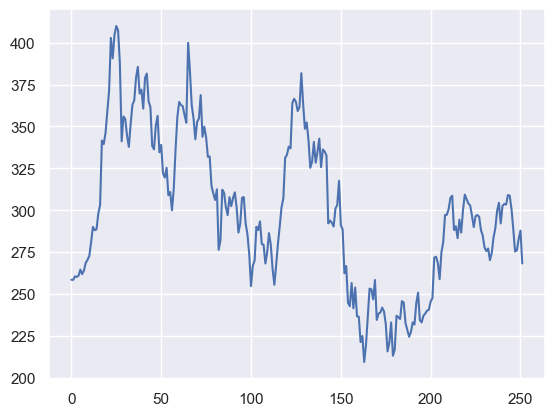

In [6]:
plt.plot(tsla_df['close'].values)

### Generate Useful Features

In [7]:
features = pd.DataFrame()
#normalize close, volume, high-low with respect to moving min/max
features['close'] = normalize_close(tsla_df)
features['volume'] = normalize_volume(tsla_df)
features['day_HL'] = normalize_HL(tsla_df)
features['sma'] = simple_moving_average(features)
features['ema'] = exponential_moving_average(features)
features['rsi'] = calculate_rsi(features)/10
features['macd_line'] , features['macd_signal'], features['macd_histogram'] = calculate_macd(features)
features['bb_middle'], features['bb_upper'], features['bb_lower'] = bollinger_bands(features)
features['target'] = calculate_closing_diff(features)

#only keep window-end samples before full window are invalid
features = features[window:]
features.head()

,close,volume,day_HL,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,target
30,0.634036,-0.225144,1.205485,0.922112,0.820391,2.659657,0.028582,0.104261,-0.075679,0.922112,1.205396,0.638828,-0.009765
31,0.562695,-0.123877,0.834094,0.900247,0.795848,2.437266,0.006179,0.084645,-0.078465,0.900247,1.222978,0.577515,-0.071342
32,0.518116,0.185585,1.239311,0.876152,0.769398,2.384661,-0.014999,0.064716,-0.079715,0.876152,1.237204,0.515101,-0.044578
33,0.608239,-0.103368,1.246601,0.859642,0.754049,2.908123,-0.024231,0.046927,-0.071158,0.859642,1.238461,0.480822,0.090122
34,0.682958,0.042524,1.399640,0.846061,0.747279,3.432200,-0.025228,0.032496,-0.057723,0.846061,1.229990,0.462131,0.074719


### Generate GRU train and test split

In [8]:
target = -1 #predict closing delta
#target = 0 #predict closing
data = features.to_numpy()
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=target, pred_size=2)
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))
test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (200, 20, 13)
> Data y: (200, 2)
Train Set
> Data X: (170, 20, 13)
> Data y: (170, 2)
Test Set
> Data X: (30, 20, 13)
> Data y: (30, 2)


### Define Model

In [9]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [10]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=2, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0190  


In [11]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=100,
    batch_size=128
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0173 - val_loss: 1.0259
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.7430 - val_loss: 0.1189
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0790 - val_loss: 0.0249
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0219 - val_loss: 0.0703
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0603 - val_loss: 0.0512
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0447 - val_loss: 0.0197
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0166 - val_loss: 0.0408
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0260 - val_loss: 0.0749
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0479 - val_loss: 0.0629
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0396 - val_loss: 0.0352
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0219 - val_loss: 0.0204
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0144 - val_loss

### Plot Performance

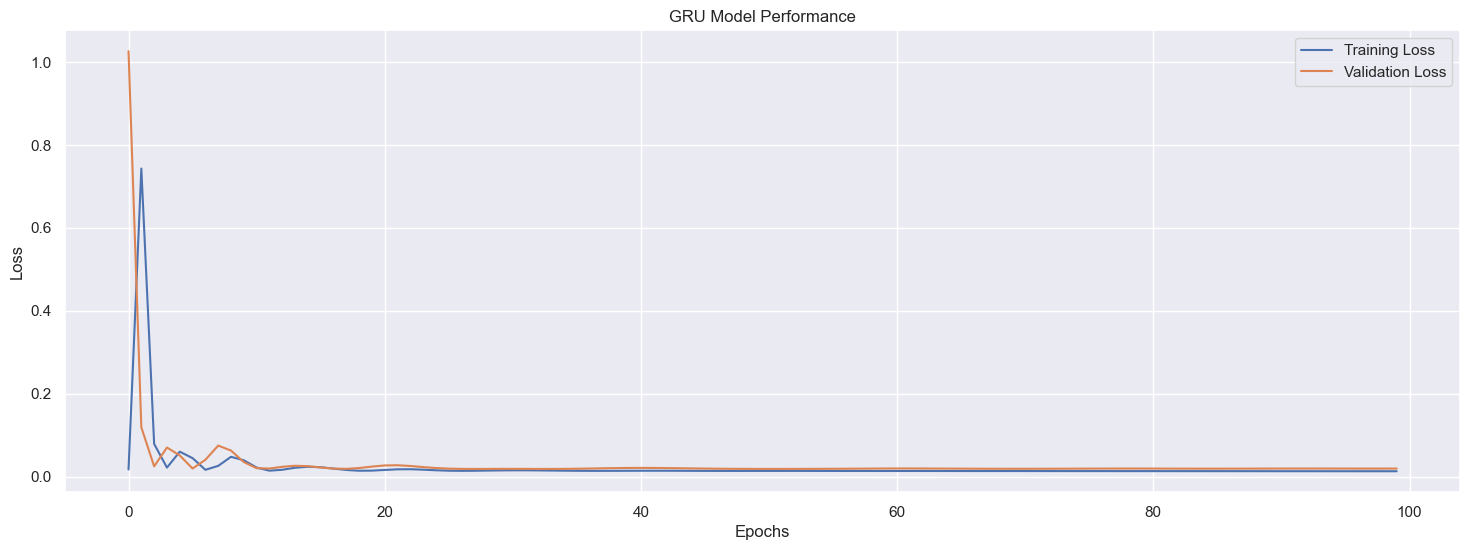

In [12]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


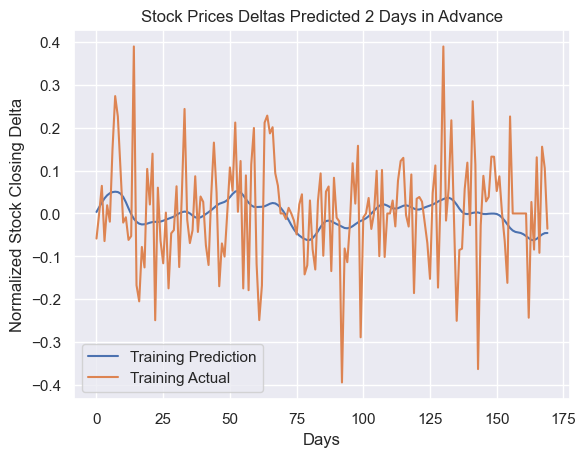

In [16]:
train_predictions = mymodel.predict(datax_train)
train_actual = datay_train
plt.plot(train_predictions[:, 1], label='Training Prediction')
plt.plot(train_actual[:, 1], label='Training Actual')
plt.title('Stock Prices Deltas Predicted 2 Days in Advance')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

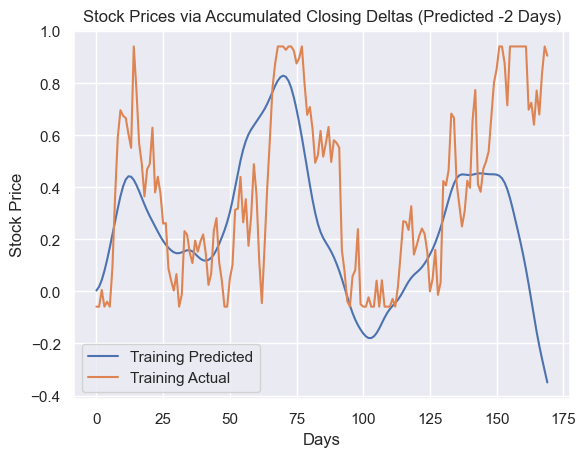

In [22]:
stock_price_train_pred = np.cumsum(train_predictions[:, 1])
stock_price_train_actual = np.cumsum(train_actual[:, 1])
plt.plot(stock_price_train_pred, label='Training Predicted')
plt.plot(stock_price_train_actual, label='Training Actual')
plt.title('Stock Prices via Accumulated Closing Deltas (Predicted -2 Days)')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()

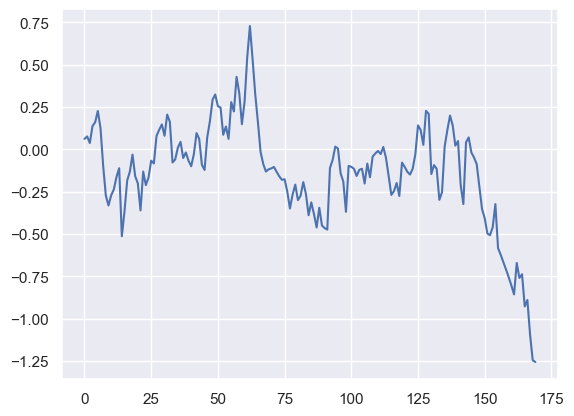

In [21]:
diff2 = stock_price_train_pred - stock_price_train_actual
plt.plot(diff2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


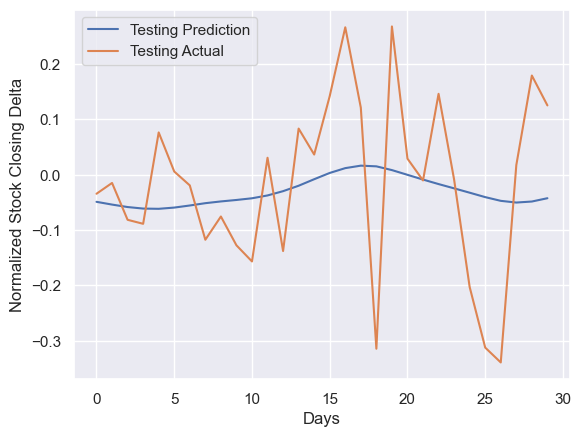

In [23]:
test_predictions = mymodel.predict(datax_test)
test_actual = datay_test
plt.plot(test_predictions[:, 1], label='Testing Prediction')
plt.plot(test_actual[:, 1], label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Normalized Stock Closing Delta')
plt.legend()

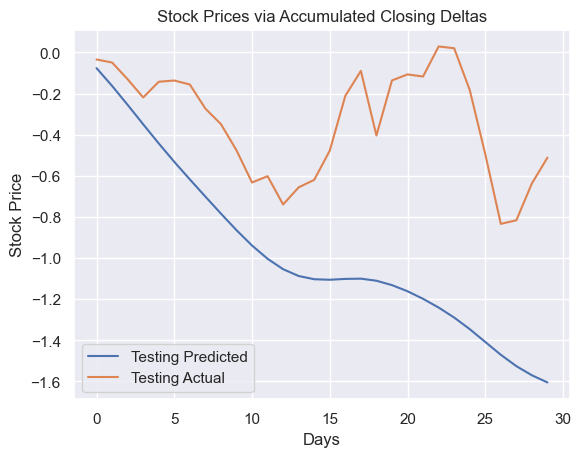

In [468]:
stock_price_test_pred = np.cumsum(test_predictions)
stock_price_test_actual = np.cumsum(test_actual)
plt.plot(stock_price_test_pred, label='Testing Predicted')
plt.plot(stock_price_test_actual, label='Testing Actual')
plt.title('Stock Prices via Accumulated Closing Deltas')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()